####     From this notebook we get:
        "Figure 06: Total fuel using and emissions of a round trip influenced by engine constructed years".
####    General steps:
        -First we create and run the basic simulation of the ship sailing on the waterway.
        -Then we plot the figure based on the results of the fuel consumption and emissions from the simulation.

## Basic simulation - consumes energy-van Dosser actual draught&payload
We are going to make a simulation which forces a vessel to move over a certain 1D waterway network. It tries to give one an understanding of the most basic core functions of OpenTNSim and teach one the requirements to set-up a basic OpenTNSim model run. 

We add some properties to the graph (depth) and the vessel (VesselProperties, ConsumesEnergy) in order to calculate resistance, required power, 

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

# turn on debug messages
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages
logging.basicConfig(level=logging.INFO)

### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).


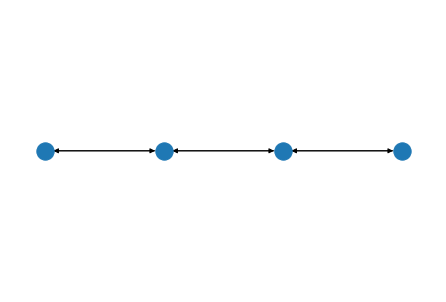

In [2]:
FG = nx.DiGraph()
nodes = []
path = []

Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

data_node_1 = {"name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"name": "Node 2",
               "geometry": shapely.geometry.Point(0.8983, 0)}  # 0.8983 degree =100km
data_node_3 = {"name": "Node 3",
               "geometry": shapely.geometry.Point(1.7966, 0)}   # 1.7966 degree =200km
data_node_4 = {"name": "Node 4",
               "geometry": shapely.geometry.Point(2.6949, 0)}    # 2.6949 degree =300km

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3], # From node 4 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_2, node_1]] # From node 2 to node 1

for edge in path:
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": 6})
    
middle_edges = [
    (node_2.name, node_3.name),
    (node_3.name, node_2.name)
]

for e in middle_edges:
    edge = FG.edges[e]
    edge['Info']['GeneralDepth'] = 6
    
# env.FG = FG
nx.draw(FG, positions)
plt.show()

In [3]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 1', 'Node 2') is 6
General depth for edge ('Node 2', 'Node 3') is 6
General depth for edge ('Node 2', 'Node 1') is 6
General depth for edge ('Node 3', 'Node 4') is 6
General depth for edge ('Node 3', 'Node 2') is 6
General depth for edge ('Node 4', 'Node 3') is 6


### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption. 

In [4]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [5]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later

data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 3.5,  # m/s
               "type":None,
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": 3.5,
               "safety_margin": 0.2, # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
               "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False
               "P_installed": 1750.0,
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }             

vessel = TransportResource(**data_vessel)

### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [6]:
path = nx.dijkstra_path(FG, node_1.name, node_4.name)

### Run simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [7]:
def run_simulation(C_year):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.C_year = C_year
    depths = []
    for e in zip(vessel.route[:-1], vessel.route[1:]):
        edge = env.FG.edges[e]
        depth = edge['Info']['GeneralDepth']
        depths.append(depth)


    for depth in depths:
            h_0 = depth
            h_0 = vessel.calculate_h_squat(v = vessel.v, h_0 = h_0)
            print(h_0)
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

In [8]:
input_data = {'C_year': [1970, 1980, 1990, 2000, 2010, 2020]}
input_data

{'C_year': [1970, 1980, 1990, 2000, 2010, 2020]}

In [9]:
# create empty plot data
plot_data = {}

# loop through the various input data
for index, value in enumerate(input_data['C_year']):
    
    # Run a basic simulation with V_s and P_tot_given combi
    vessel = run_simulation(input_data['C_year'][index])
    
    # create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    # create dataframe from energy calculation computation
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    # add/modify some comlums to suit our plotting needs
    df['total_fuel_consumption_600km']=df['total_fuel_consumption']*6/1000  #kg, a round trip is 600km in total
    df['total_emission_CO2_600km']=df['total_emission_CO2']*6/1000          #kg
    df['total_emission_PM10_600km']=df['total_emission_PM10']*6/1000        #kg
    df['total_emission_NOX_600km']=df['total_emission_NOX']*6/1000          #kg

   
    # Note that we make a dict to collect all plot data. 
    # We use labels like ['c_year = 1970'] organise the data in the dict

    label = 'C_year = ' + str(input_data['C_year'][index]) 
    plot_data[label + ', total_fuel_consumption_600km']   = list(df.total_fuel_consumption_600km[[0]])
    plot_data[label + ', total_emission_CO2_600km']   = list(df.total_emission_CO2_600km[[0]])
    plot_data[label + ', total_emission_PM10_600km']   = list(df.total_emission_PM10_600km[[0]])
    plot_data[label + ', total_emission_NOX_600km']   = list(df.total_emission_NOX_600km[[0]])
    

5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762
5.816966883955762


C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWar

In [10]:
# this is now in the plot data
plot_data

{'C_year = 1970, total_fuel_consumption_600km': [5508.497513535033],
 'C_year = 1970, total_emission_CO2_600km': [18251.00514933089],
 'C_year = 1970, total_emission_PM10_600km': [14.320374034936394],
 'C_year = 1970, total_emission_NOX_600km': [244.53711953900103],
 'C_year = 1980, total_fuel_consumption_600km': [5508.497513535033],
 'C_year = 1980, total_emission_CO2_600km': [17237.060418812507],
 'C_year = 1980, total_emission_PM10_600km': [14.320374034936394],
 'C_year = 1980, total_emission_NOX_600km': [235.4801891857047],
 'C_year = 1990, total_fuel_consumption_600km': [5508.497513535033],
 'C_year = 1990, total_emission_CO2_600km': [16850.79575956741],
 'C_year = 1990, total_emission_PM10_600km': [9.54691602329093],
 'C_year = 1990, total_emission_NOX_600km': [228.6874914207324],
 'C_year = 2000, total_fuel_consumption_600km': [5508.497513535033],
 'C_year = 2000, total_emission_CO2_600km': [15692.001781832114],
 'C_year = 2000, total_emission_PM10_600km': [7.160187017468197],
 

## Figure 15
Total fuel using and emissions of a round trip influenced by engine constructed years. An  M8 ship equipped with the engine constructed in 1970, 1980, 1990, 2000, 2010, 2020 years, respectively, sailing at 3.5 m/s in the waterway with 6 m water depth

The below results of fuel (diesel) using, emissions at different engine ages used for Figure 15 are calculated from the above simulation by changing engine construction years.

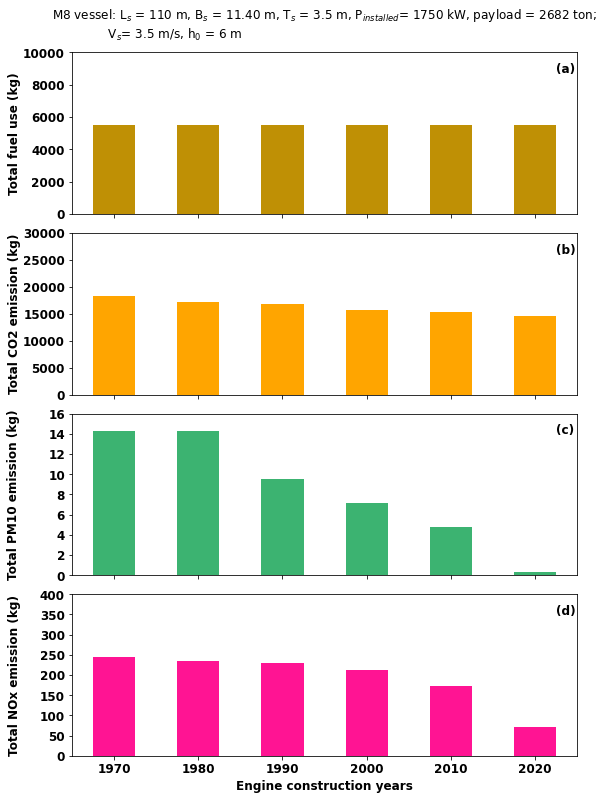

In [11]:
# use values from the output_plot variable

diesel=(plot_data['C_year = 1970, total_fuel_consumption_600km'],
        plot_data['C_year = 1980, total_fuel_consumption_600km'],
        plot_data['C_year = 1990, total_fuel_consumption_600km'],
        plot_data['C_year = 2000, total_fuel_consumption_600km'],
        plot_data['C_year = 2010, total_fuel_consumption_600km'],
        plot_data['C_year = 2020, total_fuel_consumption_600km'])

CO2 =(plot_data['C_year = 1970, total_emission_CO2_600km'],
      plot_data['C_year = 1980, total_emission_CO2_600km'],
      plot_data['C_year = 1990, total_emission_CO2_600km'],
      plot_data['C_year = 2000, total_emission_CO2_600km'],
      plot_data['C_year = 2010, total_emission_CO2_600km'],
      plot_data['C_year = 2020, total_emission_CO2_600km'] ) 

PM10 = (plot_data['C_year = 1970, total_emission_PM10_600km'],
        plot_data['C_year = 1980, total_emission_PM10_600km'],
        plot_data['C_year = 1990, total_emission_PM10_600km'],
        plot_data['C_year = 2000, total_emission_PM10_600km'],
        plot_data['C_year = 2010, total_emission_PM10_600km'],
        plot_data['C_year = 2020, total_emission_PM10_600km'] ) 
NOx =(plot_data['C_year = 1970, total_emission_NOX_600km'],
      plot_data['C_year = 1980, total_emission_NOX_600km'],
      plot_data['C_year = 1990, total_emission_NOX_600km'],
      plot_data['C_year = 2000, total_emission_NOX_600km'],
      plot_data['C_year = 2010, total_emission_NOX_600km'],
      plot_data['C_year = 2020, total_emission_NOX_600km']) 

df1 = pd.DataFrame(diesel, columns=['Fuel consumption (kg)'])
df2 = pd.DataFrame(CO2, columns=['CO2 emission (kg)'])
df3 = pd.DataFrame(PM10, columns=['PM10 emission (kg)'])
df4 = pd.DataFrame(NOx, columns=['NOx emission (kg)'])

fig, ((ax1),(ax2),(ax3),(ax4)) = plt.subplots(4,1,figsize=(8, 11),sharex=True, constrained_layout=True)

plt.subplot(411)

plt.title('M8 vessel: L$_s$ = 110 m, B$_s$ = 11.40 m, T$_s$ = 3.5 m, P$_{installed}$= 1750 kW, payload = 2682 ton;\n V$_s$= 3.5 m/s, h$_0$ = 6 m                                                                                ',y=1.05)

df1.plot(color= '#bf9005',rot=0,kind='bar', ax=ax1)
plt.ylabel('Total fuel use (kg)',fontsize=12,fontweight='bold',labelpad=2)
plt.xticks([0, 1, 2,3,4,5], ['1970','1980','1990','2000','2010','2020'],rotation=0) 
plt.yticks( weight = 'bold',fontsize=12)
plt.ylim(0, 10000)
plt.legend('',frameon=False)
plt.text(5.25, 10000*7/8, '(a)', fontsize=12,weight = 'bold')

plt.subplot(412)
df2.plot( color= 'orange',rot=0,fontsize=12,kind='bar', ax=ax2)
plt.ylabel('Total CO2 emission (kg)',fontsize=12,fontweight='bold',labelpad=2)
plt.xticks([0, 1, 2,3,4,5], ['1970','1980','1990','2000','2010','2020'],rotation=0) 
plt.yticks( weight = 'bold',fontsize=12)
plt.ylim(0, 30000)
plt.legend('',frameon=False)
plt.text(5.25, 30000*7/8, '(b)', fontsize=12,weight = 'bold')

plt.subplot(413)
df3.plot( color= 'mediumseagreen',rot=0,fontsize=12,kind='bar', ax=ax3)
plt.ylabel('Total PM10 emission (kg)',fontsize=12,fontweight='bold',labelpad=28)
plt.yticks( weight = 'bold',fontsize=12)
plt.xticks([0, 1, 2,3,4,5], ['1970','1980','1990','2000','2010','2020'],rotation=0) 
plt.ylim(0, 16)
plt.legend('',frameon=False)
plt.text(5.25, 16*7/8, '(c)', fontsize=12,weight = 'bold')

plt.subplot(414)
df4.plot(color= 'deeppink',rot=0,fontsize=12,kind='bar', ax=ax4)
plt.ylabel('Total NOx emission (kg)',fontsize=12,fontweight='bold',labelpad=19)
plt.xticks([0, 1, 2,3,4,5], ['1970','1980','1990','2000','2010','2020'],rotation=0, weight = 'bold',fontsize=12)
plt.yticks( weight = 'bold',fontsize=12)
plt.ylim(0, 400)
plt.xlabel("Engine construction years",fontsize=12,fontweight='bold')
plt.legend('',frameon=False)
plt.text(5.25, 400*7/8, '(d)', fontsize=12,weight = 'bold')

plt.savefig('Fig_06.pdf', bbox_inches = 'tight',dpi=600, format='pdf')

plt.show()